Hello 🙌, welcome to my notebook. In this notebook we will try to make Retail Analytics, Exploratory Data Analysis (EDA) and also develop and evaluate model to predict Sales. Feel free if you have any question or suggestion! Thank you!

# Feature Defenition

- Context: One challenge of modeling retail data is the need to make decisions based on limited history. Holidays and select major events come once a year, and so does the chance to see how strategic decisions impacted the bottom line. In addition, markdowns are known to affect sales – the challenge is to predict which departments will be affected and to what extent.

- Content: You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

1. Stores: Anonymized information about the 45 stores, indicating the type and size of store

2. Features: Contains additional data related to the store, department, and regional activity for the given dates.

    - Store - the store number
    - Date - the week
    - Temperature - average temperature in the region
    - Fuel_Price - cost of fuel in the region
    - MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for  all stores all the time. Any missing value is marked with an NA
    - CPI - the consumer price index
    - Unemployment - the unemployment rate
    - IsHoliday - whether the week is a special holiday week


3. Sales: Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

    - Store - the store number
    - Dept - the department number
    - Date - the week
    - Weekly_Sales -  sales for the given department in the given store
    - IsHoliday - whether the week is a special holiday week
    

- The Task

    1. Predict the department-wide sales for each store for the following year
    2. Model the effects of markdowns on holiday weeks
    3. Provide recommended actions based on the insights drawn, with prioritization placed on largest business impact

# Import Data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data1 = pd.read_csv('../input/retaildataset/stores data-set.csv')
data2 = pd.read_csv('../input/retaildataset/Features data set.csv')
data3 = pd.read_csv('../input/retaildataset/sales data-set.csv')

In [2]:
data1.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [3]:
data2.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
data3.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


- First we import all the data available
- And then take a preview about the data
- For the first section, i want to take a deeper look about first data which is Store Data

# Stores Data

In [5]:
data1.shape

(45, 3)

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [7]:
'''Nunique Columns'''

def nunique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
    
nunique_counts(data1)

Store :  45
Type :  3
Size :  40


In [8]:
data1['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

Text(0.5, 1.0, 'Ratio of missing values per columns')

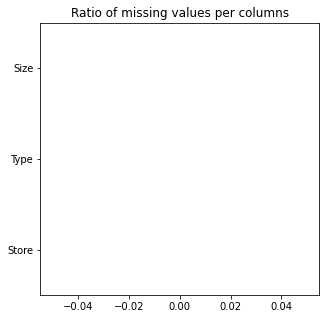

In [9]:
'''Missing Value Chart'''
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
data1.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [10]:
'''Checking Duplicate'''

print('Dupplicate entries: {}'.format(data1.duplicated().sum()))
# data1.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [11]:
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go 
import plotly.tools as tools
import warnings
from collections import Counter 
import plotly.express as px

labels = data1['Store'].tolist()
values = data1['Size'].tolist()

fig = px.pie(data1, values=values, names=labels)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Store by Size')
fig.show()

In [12]:
custom_aggregation = {}
custom_aggregation["Size"] = "mean"
data0 = data1.groupby("Type").agg(custom_aggregation)
data0.columns = ["Size"]
data0['Type'] = data0.index

fig = px.bar(data0, x='Type', y="Size", color="Type")
fig['layout'].update(height=400, width=550, title='Size of Type Store')
fig.show()

In [13]:
custom_aggregation = {}
custom_aggregation["Store"] = "count"
data0 = data1.groupby("Type").agg(custom_aggregation)
data0.columns = ["Store Count"]
data0['Type'] = data0.index

fig = px.bar(data0, x='Type', y="Store Count", color="Type")
fig['layout'].update(height=400, width=550, title='Nb. of Store Based on Type Store')
fig.show()

- From Store by Size graph, we can see that the majority of the store have similar size around(1,77% - 3,75%)
- Typa A store have store count more that other type store (B and C), and also have the largest size

# Features Data

In [14]:
data2.shape

(8190, 12)

In [15]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [16]:
nunique_counts(data2)

Store :  45
Date :  182
Temperature :  4178
Fuel_Price :  1011
MarkDown1 :  4023
MarkDown2 :  2715
MarkDown3 :  2885
MarkDown4 :  3405
MarkDown5 :  4045
CPI :  2505
Unemployment :  404
IsHoliday :  2


In [17]:
data2['IsHoliday'].unique()

array([False,  True])

Text(0.5, 1.0, 'Ratio of missing values per columns')

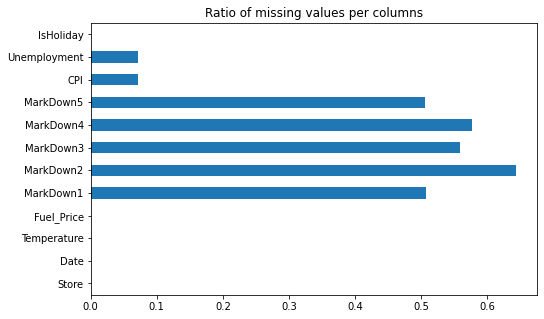

In [18]:
plt.figure(figsize=(8, 5))
data2.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [19]:
data2.isnull().sum().sort_values(ascending=False)

MarkDown2       5269
MarkDown4       4726
MarkDown3       4577
MarkDown1       4158
MarkDown5       4140
CPI              585
Unemployment     585
Store              0
Date               0
Temperature        0
Fuel_Price         0
IsHoliday          0
dtype: int64

In [20]:
data2[data2.isnull().T.any().T].head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [21]:
data2.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [22]:
data2['Date'] = pd.to_datetime(data2['Date']) #datetime format
data3['Date'] = pd.to_datetime(data3['Date']) #datetime format
data2['Year'] = data2['Date'].dt.year # getting year
data2['Month'] = data2['Date'].dt.month # getting month
data2['Day'] = data2['Date'].dt.day # getting day

In [23]:
'''Equidistance Checking'''

data0 = data2.sort_values(by='Date')
data0['Time_Interval'] = data0.Date - data0.Date.shift(1)
data0[['Date', 'Time_Interval']].head()

print(f"{data0['Time_Interval'].value_counts().sort_values(ascending=False)}")

0 days     8008
7 days       77
3 days       19
8 days       17
10 days      10
11 days       9
6 days        9
1 days        7
4 days        5
12 days       5
5 days        4
13 days       4
9 days        4
15 days       2
14 days       2
18 days       1
33 days       1
63 days       1
25 days       1
21 days       1
27 days       1
2 days        1
Name: Time_Interval, dtype: int64


In [24]:
data2['Date'].min(), data2['Date'].max()

(Timestamp('2010-01-10 00:00:00'), Timestamp('2013-12-07 00:00:00'))

- After checking missing values, the most feature which have missing values are Markdown 1-5. Also Unemploymnet and CPI
- For now I'll leave the data as it is
- And for the Date, i convert it to datetimeformat. And also generate Year, Month and Day for further modeling

In [25]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["CPI"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["CPI"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['CPI'].tolist()
y_ = data0['CPI'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='CPI'), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate CPI'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Consumer Price Index (Average)')
fig.show()

In [26]:
fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["Unemployment"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Unemployment"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['Unemployment'].tolist()
y_ = data0['Unemployment'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Unemployment',line=dict(color='firebrick', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate Unemployment'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Unemployment Index (Average)')
fig.show()

In [27]:
fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["Temperature"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Temperature"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['Temperature'].tolist()
y_ = data0['Temperature'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Temperature',line=dict(color='green', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate Temperature'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Temperature (Average)')
fig.show()

In [28]:
fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["Fuel_Price"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Fuel_Price"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['Fuel_Price'].tolist()
y_ = data0['Fuel_Price'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Fuel_Price',line=dict(color='pink', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate Fuel_Price'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Fuel_Price (Average)')
fig.show()

- The idea of what i'm doing is: i try to resample the date to monthly basis to make visualization much clear
- We can see that the original data contain Nan data, and i use interpolate to complement the visualization.
- I prefer to use interpolate compared to mean, median etc
- As we can see, monthly Consumer Price Index (CPI) is increasing every month.

'Consumer Price Index (CPI) is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care. It is calculated by taking price changes for each item in the predetermined basket of goods and averaging them.' (www.investopedia.com)

- For the unemployment, is decrease every month.
- Temperatures vary each year, usually reaching the highest peak in May - August and the lowest in Nov - Feb.
- For fuel prices experienced a significant increase in January 2011 and did not experience a decline thereafter. In fact, the price tends to increase every month.

In [29]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown1"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown1"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown1'].tolist()
y_ = data0['MarkDown1'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown1',line=dict(color='darkorchid', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown1'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)

#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown1 (Average)')
fig.show()

In [30]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown2"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown2"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown2'].tolist()
y_ = data0['MarkDown2'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown2',line=dict(color='turquoise', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown2'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)


#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown2 (Average)')
fig.show()

In [31]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown3"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown3"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown3'].tolist()
y_ = data0['MarkDown3'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown3',line=dict(color='peru', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown3'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)


#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown3 (Average)')
fig.show()

In [32]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown4"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown4"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown4'].tolist()
y_ = data0['MarkDown4'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown4',line=dict(color='rosybrown', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown4'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)


#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown4 (Average)')
fig.show()

In [33]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown5"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown5"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown5'].tolist()
y_ = data0['MarkDown5'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown5',line=dict(color='navy', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown5'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)

#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown5 (Average)')
fig.show()

- I counted the total week which is special week and visualize it in purple bar chart below the markdown chart
- And also plot the sales which overlay the markdown so that we can understand the relatiobship between sales, markdown and special week
- I make different visualization in every markdown
1. Markdown 1: The highest amount of markdown is in February - March 2012, but in that time there is no special week. Also the sales tends to stagnate. In Oct, Nov, Dec have 1 specal week but there is no markdown on that time.
2. Markdown 2: On Nov - Dec 2011 there are lots of special week, and the markdown also high. The sales experienced a significant increase at that time.
3. Markdown 3: On this type of Markdown, there are only 2 significant peaks which is in November 2011 and November 2012. In that month there is also a special week. But sales only increased significantly in November 2011.
4. Markdown 4: The highest markdown given is in Februari - March 2012 but not followed with occurrence of special week
5. Markdown 5: The amount of markdown in this type is lower than the others

# Sales Data

In [34]:
data3.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [35]:
data3.shape

(421570, 5)

In [36]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [37]:
data3.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [38]:
nunique_counts(data3)

Store :  45
Dept :  81
Date :  143
Weekly_Sales :  359464
IsHoliday :  2


Text(0.5, 1.0, 'Ratio of missing values per columns')

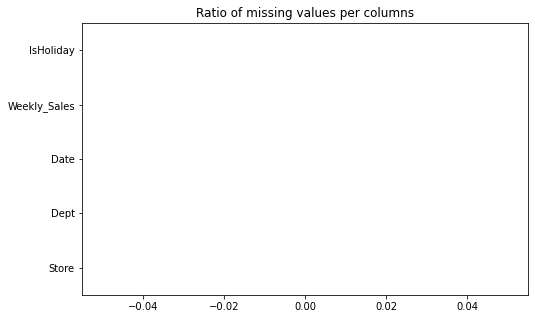

In [39]:
plt.figure(figsize=(8, 5))
data3.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [40]:
'''Checking Duplicate'''

print('Dupplicate entries: {}'.format(data3.duplicated().sum()))
# data3.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [41]:
data3.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [42]:
fig = make_subplots(rows=1, 
                    cols=1)

data3_0 = data3.loc[data3['Weekly_Sales'] < 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Lose Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Lose Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Lose Sales',line=dict(color='red', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Overall Monthly Lose Sales')
fig.show()

In [43]:
data3_0 = data3.loc[data3['Weekly_Sales'] < 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Store").agg(custom_aggregation)
data0.columns = ["Lose Sales"]
data0['Store'] = data0.index
data0['Lose Sales'] = abs(data0['Lose Sales'])

Store = data0['Store'].tolist()
Sales = data0['Lose Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Store)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Lose Sales by Store')
fig.show()

In [44]:
data3_0 = data3.loc[data3['Weekly_Sales'] < 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Dept").agg(custom_aggregation)
data0.columns = ["Lose Sales"]
data0['Dept'] = data0.index
data0['Lose Sales'] = abs(data0['Lose Sales'])

Dept = data0['Dept'].tolist()
Sales = data0['Lose Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Dept)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Lose Sales by Dept')
fig.show()

In [45]:
fig = make_subplots(rows=1, 
                    cols=1)

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Overall Monthly Profit Sales')
fig.show()

In [46]:
data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Store").agg(custom_aggregation)
data0.columns = ["Profit Sales"]
data0['Store'] = data0.index

Store = data0['Store'].tolist()
Sales = data0['Profit Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Store)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Profit Sales by Store')
fig.show()

In [47]:
data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Dept").agg(custom_aggregation)
data0.columns = ["Profit Sales"]
data0['Dept'] = data0.index

Dept = data0['Dept'].tolist()
Sales = data0['Profit Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Dept)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Profit Sales by Dept')
fig.show()

In [48]:
fig = make_subplots(rows=1, 
                    cols=1)

# Bad performance store
data3_0 = data3.loc[data3['Store'] == 28]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

# Good performance store
data3_0 = data3.loc[data3['Store'] == 20]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x_ = data0['Date_'].tolist()
y_ = data0['Monthly Profit Sales'].tolist()


fig.add_trace(go.Scatter(x=x, y=y,name='Store 28 (Bad Perf.)',line=dict(color='red', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x_, y=y_,name='Store 20 (Good Perf.)',line=dict(color='darkgreen', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Compared Good and Bad Store Performance based on Monthly Profit Sales')
fig.show()

In [49]:
fig = make_subplots(rows=1, 
                    cols=1)

# Bad performance store
data3_0 = data3.loc[data3['Dept'] == 32]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

# Good performance store
data3_0 = data3.loc[data3['Dept'] == 92]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x_ = data0['Date_'].tolist()
y_ = data0['Monthly Profit Sales'].tolist()


fig.add_trace(go.Scatter(x=x, y=y,name='Dept 32 (Bad Perf.)',line=dict(color='red', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x_, y=y_,name='Dept 92 (Good Perf.)',line=dict(color='darkgreen', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Compared Good and Bad Dept Performance based on Monthly Profit Sales')
fig.show()

- I seperate the lose sales (negative) and the profit sales (positive). This is so that we can clearly see in what month the biggest loss occurred, because when we do aggregation using the mean there will be bias in the visualization. 
- I also find out what store and dept both giving big loses or profit
- After it i also compare both store and dept which giving the highest proft and the lowest profit.
- For the monthly loses, we can see that Feb, Aug, Sep which is usually the most significant sales decrease occurs.
- The worst performance is Store number 28 (-16.8%), and Dept number 32 (-19.35%)
- The best performance is Store number 20 (+4.25%), and Dept number 92 (+6.61%)
- For Store number 28 have size 3.52% and Store number 20 3.48%. We can see that the size of the two store is not too different, but the difference in sales about 10K. It means that, the management shoult take aware of this thing, why Store number 28 hav very bad performance, while the operational costs incurred are not much different from those of the best performing stores.
- And for Dept number 32 and 92 have very significant different in sales, which is about 50K
- Need further inspection about Dept number 32, because it give very low profit in the business.

# Predicting Sales

In [50]:
all_data = data1.merge(data2).merge(data3)

In [51]:
all_data.head()

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Dept,Weekly_Sales
0,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,1,24924.50
1,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,2,50605.27
2,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,3,13740.12
3,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,4,39954.04
4,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,5,32229.38


Text(0.5, 1.0, 'Ratio of missing values per columns')

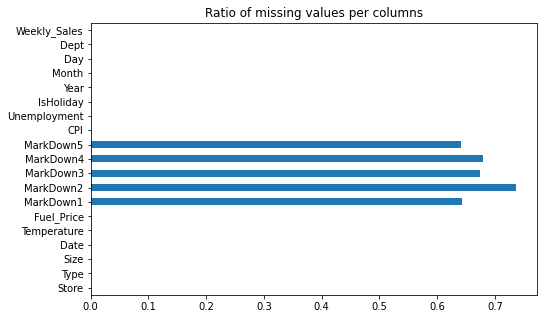

In [52]:
plt.figure(figsize=(8, 5))
all_data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [53]:
all_data['Date'].min(), all_data['Date'].max()

(Timestamp('2010-01-10 00:00:00'), Timestamp('2012-12-10 00:00:00'))

In [54]:
testing = all_data.copy()

In [55]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Type          421570 non-null  object        
 2   Size          421570 non-null  int64         
 3   Date          421570 non-null  datetime64[ns]
 4   Temperature   421570 non-null  float64       
 5   Fuel_Price    421570 non-null  float64       
 6   MarkDown1     150681 non-null  float64       
 7   MarkDown2     111248 non-null  float64       
 8   MarkDown3     137091 non-null  float64       
 9   MarkDown4     134967 non-null  float64       
 10  MarkDown5     151432 non-null  float64       
 11  CPI           421570 non-null  float64       
 12  Unemployment  421570 non-null  float64       
 13  IsHoliday     421570 non-null  bool          
 14  Year          421570 non-null  int64         
 15  Month         421

In [56]:
testing.shape

(421570, 19)

In [57]:
features = testing.columns.values.tolist()

for col in features:
    testing[col] = testing[col].interpolate()

In [58]:
testing.isnull().sum().sort_values(ascending=False) #missing values culomns

MarkDown4       6587
MarkDown1       6587
MarkDown2       6587
MarkDown3       6587
MarkDown5       6587
Unemployment       0
Dept               0
Day                0
Month              0
Year               0
IsHoliday          0
Store              0
CPI                0
Type               0
Fuel_Price         0
Temperature        0
Date               0
Size               0
Weekly_Sales       0
dtype: int64

In [59]:
testing.dropna(inplace=True)

In [60]:
testing.head()

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Dept,Weekly_Sales
6587,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,1,18689.54
6588,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,2,44936.47
6589,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,3,9959.64
6590,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,4,36826.52
6591,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,5,31002.65


In [61]:
'''Checking Duplicate'''

print('Dupplicate entries: {}'.format(testing.duplicated().sum()))
# data1.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [62]:
testing = testing.drop('Date', axis=1, inplace=False)

In [63]:
nunique_counts(testing)

Store :  45
Type :  3
Size :  40
Temperature :  3488
Fuel_Price :  892
MarkDown1 :  266578
MarkDown2 :  305105
MarkDown3 :  279487
MarkDown4 :  281959
MarkDown5 :  265843
CPI :  2053
Unemployment :  342
IsHoliday :  2
Year :  3
Month :  12
Day :  31
Dept :  81
Weekly_Sales :  354138


In [64]:
'''Label Encoding With Label'''
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(testing['Type'])

testing['Type'] = le.transform(testing['Type'])

l = [i for i in range(3)]
dict(zip(list(le.classes_), l))

{'A': 0, 'B': 1, 'C': 2}

In [65]:
le.fit(testing['IsHoliday'])

testing['IsHoliday'] = le.transform(testing['IsHoliday'])

l = [i for i in range(2)]
dict(zip(list(le.classes_), l))

{False: 0, True: 1}

In [66]:
'''Min Max Scaler'''

from sklearn.preprocessing import MinMaxScaler

def normalize_col(data):
    for col in testing.columns.values.tolist():
        scaler = MinMaxScaler()
        data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
    return data

testing = normalize_col(testing)
testing.head()

,Store,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Dept,Weekly_Sales
6587,0.0,0.0,0.630267,0.598532,0.413327,0.117124,0.0609,0.001724,0.035664,0.059199,0.90872,0.382116,0.0,0.5,0.909091,0.333333,0.000000,0.033919
6588,0.0,0.0,0.630267,0.598532,0.413327,0.117124,0.0609,0.001724,0.035664,0.059199,0.90872,0.382116,0.0,0.5,0.909091,0.333333,0.010204,0.071517
6589,0.0,0.0,0.630267,0.598532,0.413327,0.117124,0.0609,0.001724,0.035664,0.059199,0.90872,0.382116,0.0,0.5,0.909091,0.333333,0.020408,0.021414
6590,0.0,0.0,0.630267,0.598532,0.413327,0.117124,0.0609,0.001724,0.035664,0.059199,0.90872,0.382116,0.0,0.5,0.909091,0.333333,0.030612,0.059900
6591,0.0,0.0,0.630267,0.598532,0.413327,0.117124,0.0609,0.001724,0.035664,0.059199,0.90872,0.382116,0.0,0.5,0.909091,0.333333,0.040816,0.051557


In [67]:
testing.corr()['Weekly_Sales'].sort_values(ascending=False)[:8]

Weekly_Sales    1.000000
Size            0.245900
Dept            0.144387
MarkDown1       0.110701
MarkDown2       0.103349
MarkDown4       0.074705
MarkDown5       0.072457
MarkDown3       0.041821
Name: Weekly_Sales, dtype: float64

- The next step is modelling, from this case it categorized as Regression problem. And i will try using Logistic Regression
- I combine all the data
- And the for the data we will use from 2010-01-10 until 2012-12-10
- For the missing values we know that Markdown feature have so mach missing values. Instead to drop it, or fill it with 0 i prefer to chose interpolate
- After interpolating the feature, again checking for the missing values
- All the feature which already interpolate still have missing values, and we will drop all the rows
- And then trying to label encoding categorical data, and using min max scaler to make data tight
- For the correlation, we can see that Size, Dpet, and MarkDown strongly correlated with our target feature. Later we will use this selected feature for modelling
- After all the pre-processing step, we will start to modelling

In [68]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

In [69]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [70]:
'''LINIER REGRESION'''
#with selected feature

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import numpy as np

train_data,test_data = train_test_split(testing,train_size = 0.8,random_state=3)

features = ['Size','Dept', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
lr1 = LinearRegression()
lr1.fit(train_data[features],train_data['Weekly_Sales'])

pred1 = lr1.predict(test_data[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data['Weekly_Sales'],pred1)),'.3f'))
rtrcm1 = float(format(lr1.score(train_data[features],train_data['Weekly_Sales']),'.3f'))
artrcm1 = float(format(adjustedR2(lr1.score(train_data[features],train_data['Weekly_Sales']),train_data.shape[0],len(features)),'.3f'))
rtecm1 = float(format(lr1.score(test_data[features],test_data['Weekly_Sales']),'.3f'))
artecm1 = float(format(adjustedR2(lr1.score(test_data[features],test_data['Weekly_Sales']),test_data.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(lr1,testing[features],testing['Weekly_Sales'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Linear Regression','Selected Features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)
evaluation

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Linear Regression,Selected Features,0.031,0.084,0.084,0.082,0.082,0.07


In [71]:
'''LINIER REGRESION'''
#with all feature

features = testing.drop(['Weekly_Sales','Type', 'Size', 'Dept'], axis=1).columns.values.tolist()
lr2 = LinearRegression()
lr2.fit(train_data[features],train_data['Weekly_Sales'])

pred2 = lr2.predict(test_data[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data['Weekly_Sales'],pred2)),'.3f'))
rtrcm2 = float(format(lr2.score(train_data[features],train_data['Weekly_Sales']),'.3f'))
artrcm2 = float(format(adjustedR2(lr2.score(train_data[features],train_data['Weekly_Sales']),train_data.shape[0],len(features)),'.3f'))
rtecm2 = float(format(lr2.score(test_data[features],test_data['Weekly_Sales']),'.3f'))
artecm2 = float(format(adjustedR2(lr2.score(test_data[features],test_data['Weekly_Sales']),test_data.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(lr2,testing[features],testing['Weekly_Sales'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Linear Regression','All Features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)
evaluation

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Linear Regression,Selected Features,0.031,0.084,0.084,0.082,0.082,0.070
1,Linear Regression,All Features,0.032,0.030,0.030,0.028,0.028,0.005


In [72]:
# DISPLAY MODELLING
import seaborn as sns

def model_performance_sc_plot(predictions, labels, title):
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

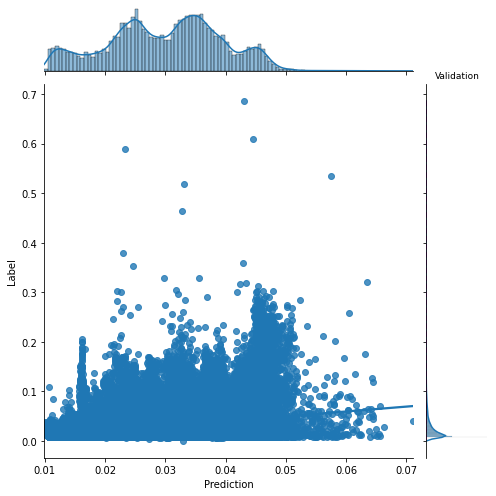

In [73]:
# LR With Selected Features
model_performance_sc_plot(pred1, test_data['Weekly_Sales'], 'Validation')

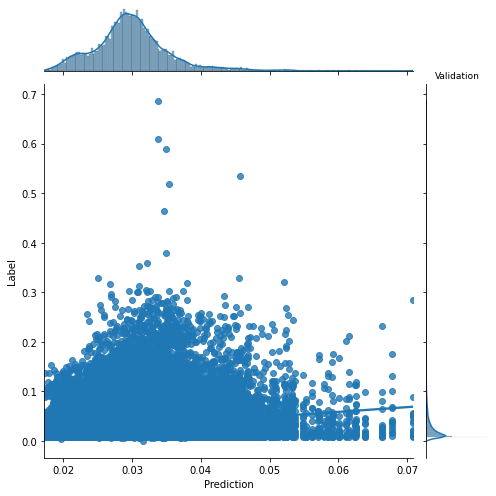

In [74]:
# LR With All Features
model_performance_sc_plot(pred2, test_data['Weekly_Sales'], 'Validation')

- For the first, i will create dataframe to input the result
- I split the train and test 80 : 20
- After all the modelling and calculate the parameter to check the model, i input it in evaluation dataframe
- And then try to make function, to visualize our result
- From the joint jointplot we can see the predicted and actual label distributin
- I prefer to use logistic regression model which input all features compare to only selected features. Its because after checking the joint plot we can see that with selected feature, model tent to have larger predicted values (not similar to actual label).

In [75]:
feature = data2.columns.values.tolist()

for col in feature:
    data2[col] = data2[col].interpolate()

In [76]:
data2.dropna(inplace=True)

In [77]:
data2['Date'].min(), data2['Date'].max()

(Timestamp('2010-01-10 00:00:00'), Timestamp('2013-12-07 00:00:00'))

In [78]:
data2 = data2.loc[data2['Date'] >= '2012-12-10 00:00:00']

In [79]:
data2['Sales Prediction'] = lr2.predict(data2[features])

In [80]:
data2.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Sales Prediction
140,1,2012-12-10,62.99,3.601,2086.18,19.695,8.11,602.36,5926.45,223.381296,6.573,False,2012,12,10,321.234494
149,1,2012-12-14,48.89,3.168,3504.83,22262.346,73.26,1636.80,2779.60,223.719277,6.573,False,2012,12,14,1035.559959
150,1,2012-12-21,56.02,3.098,8231.71,29681.738,274.00,358.15,2834.02,223.839845,6.573,False,2012,12,21,1484.211505
151,1,2012-12-28,44.79,3.108,12659.55,37101.130,174.78,74.46,1208.86,223.960414,6.573,True,2012,12,28,1836.369400
152,1,2013-04-01,41.73,3.161,1214.08,25366.330,15.01,72.36,3940.02,224.080983,6.525,False,2013,4,1,1113.926039


In [81]:
fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["Sales Prediction"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales Prediction"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales Prediction'].tolist()
y_ = data0['Monthly Profit Sales Prediction'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Avg. Sales',line=dict(color='black', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,name=' ',line=dict(color='black', width=2)), 1, 1)
#--------------------------------------------------------------------------------------------------------

custom_aggregation = {}
custom_aggregation["Sales Prediction"] = "min"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales Prediction"]
data0['Date_'] = data0.index

x_min = data0['Date_'].tolist()
y_min = data0['Monthly Profit Sales Prediction'].tolist()
y_min_ = data0['Monthly Profit Sales Prediction'].interpolate().tolist()


fig.add_trace(go.Scatter(x=x_min, y=y_min,name='Pesimistic Sales',line=dict(color='red', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x_min, y=y_min_,name=' ',line=dict(color='red', width=2)), 1, 1)
#--------------------------------------------------------------------------------------------------------

custom_aggregation = {}
custom_aggregation["Sales Prediction"] = "max"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales Prediction"]
data0['Date_'] = data0.index

x_max = data0['Date_'].tolist()
y_max = data0['Monthly Profit Sales Prediction'].tolist()
y_max_ = data0['Monthly Profit Sales Prediction'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x_max, y=y_max,name='Optimistic Sales',line=dict(color='darkgreen', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x_max, y=y_max_,name=' ',line=dict(color='darkgreen', width=2)), 1, 1)
#--------------------------------------------------------------------------------------------------------


fig['layout'].update(height=500, width=900, title='Monthly Sales Prediction')
fig.show()

- After selectin the best model, i preparing the data which we will predict (data2)
- We will range the data between 2012-12-10 untill 2013-12-07
- After predicting the sales, the we will make time frame visualization about our prediction
- Here i make monthly sales with 3 type, Average Sales (Mean weekly sales in one month), Pesimistic Sales (The minumum weekly sales in one month), and the the Optimistic Sales (The maximum weekly sales in one month)
- The sales in Feb 2013 tend to increase before it goes down. And then start increased again until its highest peak on August 2013
- Finally for answering our question, Did Sales Increase on Christmas? Yes and No! Because on real complete data we can see highest monthly sales peak are on December each year. But in our model it tend to decrease when December 2013. It may because our interpolate Markdown predict lows values after the lastest knowing Markdown. It may be in accurate for some reason.

Finish, don't forget to upvote. Thank You!:)